In [ ]:
# conda activate py3
# /usr/local/Caskroom/miniconda/base/envs/py3/bin/pip install -e .
# conda install -c anaconda graphviz,statsmodels,scikit-learn -n py3 

In [40]:
os.getcwd()

'/Users/redmo'

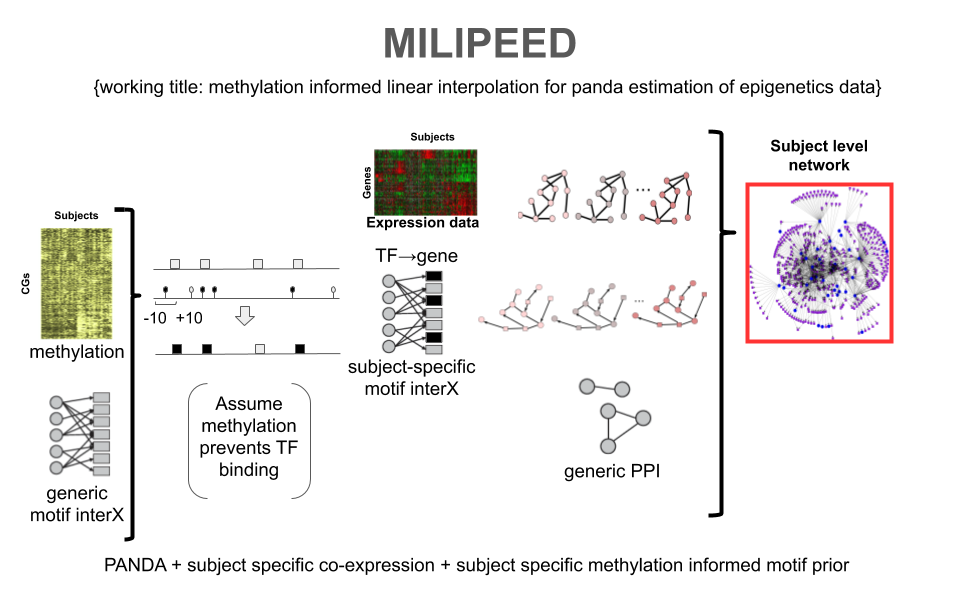

In [41]:
Image(filename='netZooPy/tests/milipeed/ToyData/MILIPEED_workflow.png')

In [2]:
import re, netZooPy, glob, os, collections, scipy
import numpy as np
import dask
from matplotlib import colors as mcolors
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, date
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
import sklearn.svm as svm
import plotly.tools as tls
from sklearn.preprocessing import label_binarize
from netZooPy.panda.panda import Panda
from netZooPy.lioness.lioness import Lioness
from netZooPy.milipeed.milipeed import Milipeed
# from netZooPy.milipeed.validate_milipeed import ValidateMilipeed

In [2]:
from multiprocessing import Process

### create hg19 metadata db to investigate only optimal IDR

In [ ]:
tfdb=pd.read_csv('A549_hg19/metadata.tsv',sep='\t',header=0)#,sep='\t',names=['motif','TF'])
aa=tfdb[['File accession','Experiment target','Output type','Assembly']]
aa['gene']=(aa['Experiment target'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_1']
aa=aa[aa['Output type']=='optimal IDR thresholded peaks']
aa=aa[aa['Assembly']=='hg19']
del aa['Experiment target'],aa['Output type'],aa['Assembly']
aa.to_csv(('A549_hg19/meta2IDR.txt'),sep='\t',header=False,index=False)

### format motif files to bed

In [ ]:
# path='../../../data/MotifPipeline/hg38_refseq_100kb/'
path='../../../../rekrg/EpiPANDA/FIMO_results/ScanBedResults/'
# tfdb=pd.read_csv('~/analyses/SPIDER/cisbp_nams_689_unique_hgnc_symbol.txt',sep='\t',names=['motif','TF'])
traces= os.listdir(path)
for j,trace in enumerate(traces):
    filepath = os.path.join(path, trace)
    data2=pd.read_csv(filepath,sep='\t',names=['loc','pwma','pval','gene','dist'])
#     data2=pd.read_csv(filepath,sep='\t',names=['loc','pwm','pval','gene','dist'])
    data2['chr']=(data2['loc'].str.split(':', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_1']
    data2['tmp']=(data2['loc'].str.split(':', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_2']
    data2['start']=(data2['tmp'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_1']
    data2['end']=(data2['tmp'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_2']
    del data2['tmp'], data2['loc']
    data2=data2[['chr','start','end','gene','pwm','pval','dist']]
    tt=trace.split('_', 1)[0]
    z=tfdb.TF[tt==tfdb.motif]
    data2['name']='name'+data2.index.map(str)
    if z.empty is False:
        zz=tfdb.TF[float(str(z)[0:3])]
        data2.to_csv(('../../../data/MotifPipeline/hg19_refseq_100kb_tr/'+zz+'.txt'),sep='\t',header=False,index=False)

### convert hg38 WGBS to hg19

In [ ]:
%%bash
for f in ~/data/MotifPipeline/hg19_refseq_100kb_tr/*.txt; do 
# for f in ~/data/MotifPipeline/remap/convert/*.bed; do 
#     sh script.sh "$f" > "${f%.*}_output.fasta"; 
     ~/liftOver "$f" ~/hg19ToHg38.over.chain "${f%.*}_hg38.txt" unmatched.txt
#     eval "awk '{split(\$4,a,\":\"); print \$1\"\t\"\$7\"\t\"\$8\"\t\"a[1] > \"$f"}' '${f%.*}_hg19.txt' "
done

# ./liftOver A549_hg19/ENCFF001TRO.bed hg19ToHg38.over.chain.gz A549_hg19/ENCFF001TRO.bed_hg38.bed A549_error.txt
# ~/tools/liftOver ~/data/MotifPipeline/ENCODE/wgbsin/ENCFF005TID.txt ~/hg38ToHg19.over.chain ~/data/MotifPipeline/ENCODE/wgbsin/ENCFF005TID_hg19.txt unmatched.txt

# ~/liftOver ~/data/MotifPipeline/remap/remap_hg19_ChIP.txt ~/hg319ToHg38.over.chain ~/data/MotifPipeline/remape/remap_hg38_ChIP.txt unmatched.txt


In [8]:
os.getcwd()
# os.chdir('../../../')
# os.chdir('/udd/redmo/data/MotifPipeline/ENCODE')

'/Users/redmo'

### remap wgbs metadata

In [ ]:
tfdb=pd.read_csv('~/data/MotifPipeline/ENCODE/wgbsin/cellline_metadata.txt',sep='\t',header=0)#,sep='\t',names=['motif','TF'])
aa=tfdb[['File accession','Biosample term name','Output type','Biological replicate(s)']]
# aa['gene']=(aa['Experiment target'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_1']
aa=aa[aa['Output type']=='methylation state at CpG']
# aa=aa[aa['Assembly']=='hg38']
# del aa['Experiment target'],aa['Output type'],aa['Assembly']
del aa['Output type']
aa.to_csv(('~/data/MotifPipeline/ENCODE/wgbsin/remap_cell_meta.txt'),sep='\t',header=False,index=False)

### run motif x WGBS x ChIP intersection

bash to run intersections between (1) TF chip and wgbs and (2) TF chip and motif and then (3) the intersect of both of these accounting for both motif matches and misses which lets us account for motif FP which would otherwise be sparse

In [ ]:
%% bash
###BOTH STEPS IN AUROC CALC btwn PWM + wgbsmeth + CHiP meth
## for all ChIP files associated with Motif which will me intersected with WGBS/Me array
#PARAMETER REGION

TFdir=A549_hg19/; # %%% location of ChIP bed files
tfdb=$TFdir/meta2IDR.txt # metadata file including ChIP file name and gene
motifdir=../hg19_refseq_100kb_tr/
motiffiles=$(ls $motifdir*.txt)
TFfiles=$(ls $TFdir*.bed)
bsfile=wgbsin/ENCFF005TID_hg19.txt
temp0dir=A549_hg19_out_peaks/; #output dir
rm -r -i -f $temp0dir
mkdir $temp0dir

# while read mfile #
for mfile in $motiffiles
do

if [ -e $mfile ]
then

mtag=$(eval "echo "$mfile" | cut -d / -f3|cut -d . -f1")
bstag=$(eval "echo "$bsfile" | cut -d . -f1| cut -d / -f2")

awk -v pat=$mtag '$2 ~ pat'  $tfdb | cut -f 1 | sed 's/^/A549_hg19\//'| sed 's/$/.bed/'> tempTF0.txt

if [ -s "tempTF0.txt" ]
then

tempTF1=$(cat tempTF0.txt)
cat `echo $tempTF1` | cut -f1,2,3,5| sort -V -k1,1 -k2,2n > tffile.txt
echo "$count = wgbs=$bstag gene=$gtag TF=$mtag"
sort -k1,1 -k2,2n $mfile > sort_motif.txt

### restrict WGBS to only motif regions, return both PWM and %Me
eval "~/../rekrg/Tools/bedtools2/bin/bedtools intersect -wa -wb -a sort_motif.txt -b wgbsin/ENCFF005TID.txt " > temp0a.txt
### restrict that intersection above with hits on WGBS, and if no ChIP peak return zero
eval "~/../rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a temp0a.txt -b tffile.txt" > $temp0dir$mtag$ttag 

rm -i -f -r temp0a.txt
rm -i -f -r tempTF0.txt 
rm -i -f -r tffile.txt
rm -i -f -r sort0bed.txt

fi
fi
done



### plot intersections

In [9]:
import matplotlib.backends.backend_pdf

# path='a549_hg38tr_out_orig/'
path='A549_hg19_out_peaks/'
traces= os.listdir(path)
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

for j,trace in enumerate(traces):
    filepath = os.path.join(path, trace)
#     data=pd.read_csv(filepath,sep='\t',names=["chr", "Start", "End", "ChIPTF",'gene','pwm','pval','dist',"wgbs"]) 
    data=pd.read_csv(filepath,sep='\t',names=["chrMotif", "MSS", "MES",'pwm','pval','gene','chrWGBS','WSS','WES',"wgbs",'chrChIP','CSS','CES',"ChIPTF",'idk']) 
#     data['C1']=(data['ChIPTF'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_1']

# Refit data to 0-1    
    data.ChIPTF=data.ChIPTF.replace('.','0')
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
    data.ChIPTF=data.ChIPTF/1000
    data=data[data.wgbs<=100]

    data['weight']=((data.pwm-min(data.pwm))/(max(data.pwm)-min(data.pwm)))
## Call ChIP Binding (extreme/safe binarize)
    data3=data.copy()
    df=data3.groupby(data3.gene).size().reset_index(name='counts')
    data3 = data3.groupby(data3.gene).agg({"chrMotif":'first',"MSS":'first', "MES":'first','weight':'first',"wgbs":sum,"ChIPTF":'first'})
    data3=data3.merge(df,on='gene')
    data2=data3.copy()
    data3.ChIPTF[data3.ChIPTF>0.0001]=1 ## start with 1000 confidence
    data3.ChIPTF[data3.ChIPTF<0.0001]=0
    data.wgbs=1-(data.wgbs/100)
    data3.wgbs=1-(data3.wgbs/100)
#     data3['density']=data3['counts']/((data3['End']-data3['Start'])/2)
    data3.wgbs[data3.wgbs<0]=0
    data2.wgbs=1-(data2.wgbs/100)
    data2.wgbs[data2.wgbs<0]=0
    
    if min(data3.ChIPTF)==0:
        f= plt.figure(figsize=(14, 4))
    ## Plot all three value distributions fit to same 0-1 scale
        plt.subplot(1, 5, 1)
        colors = ['wgbs','motif','ChIP']
        plt.hist([data3.wgbs,data3.weight,data3.ChIPTF],alpha=.5,log=True,stacked=False,label=colors,color=['tab:blue','deeppink','k'])
        plt.legend(loc="upper center")
        plt.xlabel('Link Weight')
        plt.ylabel('Frequency')
        plt.title('A549-'+trace+' links')

    ## Plot scatter of WGBS and motif to ChIP
        plt.subplot(1, 5, 2)
        sns.scatterplot(data.wgbs,data.ChIPTF,label='wgbs',alpha=.5)
        sns.scatterplot(data.weight,data.ChIPTF,label='motif',alpha=.5,color='deeppink').set_title("ChIP vs Motif & wgbs")

    ## Plot all ROC curves
    ###PWM
        fpr, tpr, thresholds = metrics.roc_curve(data3.ChIPTF, data3.weight)
        roc_auc=metrics.auc(fpr, tpr)
        plt.subplot(1, 5, 3)
        plt.plot(fpr, tpr,
                 label='Motif (area = {0:0.2f})'
                       ''.format(roc_auc),
                 color='deeppink', linestyle=':', linewidth=4)
    ###WGBS
        fpr, tpr, thresholds = metrics.roc_curve(data3.ChIPTF, data3.wgbs)
        roc_auc=metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='WGBS (area = {0:0.2f})'
                       ''.format(roc_auc),
                 color='tab:blue', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUROC')
        plt.legend(loc="lower right")
        plt.subplots_adjust(wspace=.5)

    ## Overlap of link calls
        fig=plt.subplot(1, 5, 5)
        labels = ['TPTP','FPFP','FNFN','TNTN','TPFN','FNTP','FPTN','TNFP']
        pwm = [
            len(data[(data.weight>.5)&(data.ChIPTF>.5)&data.wgbs>.5]),
            len(data[(data.weight>.5)&(data.ChIPTF<.5)&data.wgbs>.5]),    
            len(data[(data.weight<.5)&(data.ChIPTF>.5)&data.wgbs<.5]),
            len(data[(data.weight<.5)&(data.ChIPTF<.5)&data.wgbs<.5]),
            len(data[(data.weight>.5)&(data.ChIPTF>.5)&data.wgbs<.5]),
            len(data[(data.weight<.5)&(data.ChIPTF>.5)&data.wgbs>.5]),
            len(data[(data.weight>.5)&(data.ChIPTF<.5)&data.wgbs<.5]), 
            len(data[(data.weight<.5)&(data.ChIPTF<.5)&data.wgbs>.5])]

        x = np.arange(len(labels))
        width = 0.35
        PWM=plt.bar(x ,np.round(np.log(pwm),decimals=4),width,label='scores',color='tab:blue')
        plt.xticks(x,labels,rotation=90)
        plt.ylabel('log count')
        plt.title('matched links \n motif then wgbs')

        plt.subplot(1, 5, 4)
        colors = ['motif']
        cc=np.unique(data.gene, return_counts=True)[1]
        plt.hist(cc,alpha=.5,log=True,stacked=False,label=colors,color=['deeppink'])
        plt.legend(loc="upper right")
        plt.xlabel('motif')
        plt.ylabel('Frequency')
        plt.title('freq wbgs event \n binding in same motif')
#         plt.show()
for fig in range(1, plt.gcf().number + 1):
    pdf.savefig( fig )
pdf.close()

FileNotFoundError: [Errno 2] No such file or directory: 'A549_hg19_out_peaks/'

### Link calling paradigm

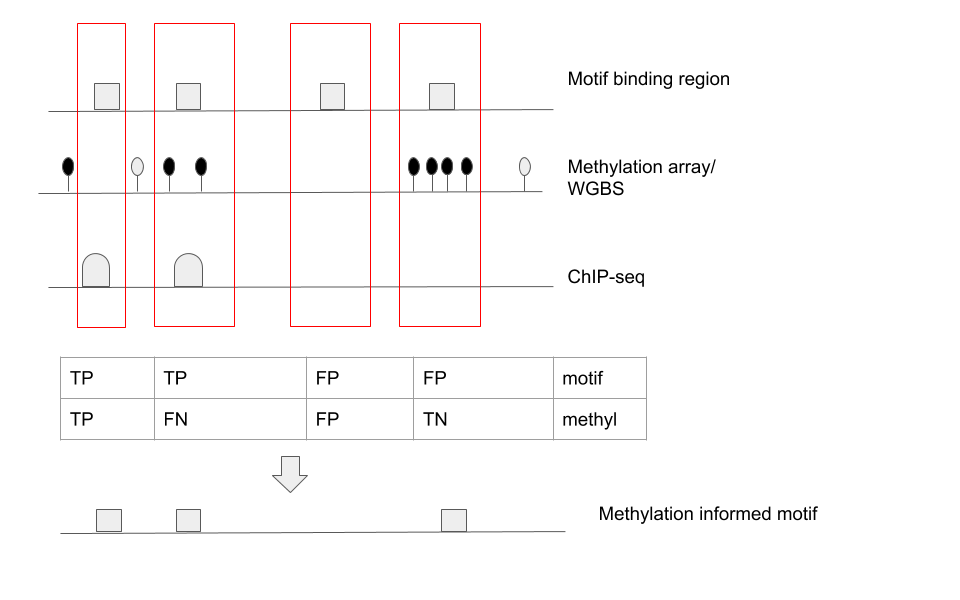

In [291]:
Image(filename='../../../analyses/MILIPEED/link_calling.png')

### multi-cell line remap version

In [ ]:
%% bash
###BOTH STEPS IN AUROC CALC btwn PWM + wgbsmeth + CHiP meth
## for all ChIP files associated with Motif which will me intersected with WGBS/Me array
#PARAMETER REGION
# validate_milipeed ChIPdir motifdir WGBSdir valoutdir {
# ChIPdir=$1 # %%% location of ChIP bed files
ChIPdir='/udd/redmo/data/MotifPipeline/remap/' ## chr start end gene-target per cell line name
# tfdb=$ChIPdir/meta2IDR.txt # metadata file including ChIP file name and gene
TFfiles=$(ls $ChIPdir*.bed)


# motifdir=$2
motifdir='/udd/redmo/data/MotifPipeline/hg38_refseq_100kb_tr_fromhg19/'  ## chr start stop pwm per gene name/
# motiffiles=$(ls $motifdir*.txt)

# WGBSdir=$3
WGBSdir='/udd/redmo/data/MotifPipeline/ENCODE/wgbsin' ## chr start end tmp Me-value, multiple per cell line
WGBSfiles=$(ls $WGBSdir/*.bed)
WGBSmeta=$WGBSdir/cellline_meta.txt


# outdir=$4
outdir='/udd/redmo/data/MotifPipeline/validate_milipeed/'
rm -r -i -f $outdir
mkdir $outdir
counter=1 
# for wfile in $WGBSfiles
# do
# echo $wfile
for tfile in $TFfiles # cell line
do

TFs=$(eval "cat "$tfile" | cut -f4 | sort | uniq")

for tf in $TFs # targeted genes in ChIP cell lines
do
tftag="${tf}.txt"  #$(eval "echo "$tfile" | cut -d / -f7")

if [ -e $motifdir/$tftag ]
then
awk 'NR > 1 || $4 == $tf' $tfile > tffile.txt ## cell-line and gene specific chip file

gtag=$(eval "echo "$tfile" | cut -d / -f7| cut -d . -f1")

###merge multiple wgbs for same cell line (replicates)
awk -v pat=$gtag '$2 ~ pat'  $WGBSmeta | cut -f 1 | sed 's/^/wgbsin\//' | sed 's/$/.bed/'> tempTF0.txt
# tempTF1=$(cat tempTF0.txt)
# cat `echo $tempTF1` | cut -f1,2,3,5| sort -V -k1,1 -k2,2n > mergeall.txt
# eval "~/../rekrg/Tools/bedtools2/bin/bedtools merge -i mergeall.txt" > tfile.txt #wgbs file

###use largest of replicates (faster)
mergeall=$(find $(< tempTF0.txt) | sort -nr | head -n 1 )

# cut -f1,2,3,5 $mergall > wfile.txt

echo "$counter : TF=$tf"
counter=$[$counter +1]
### restrict WGBS to only motif regions, return both PWM and %Me
eval "~/../rekrg/Tools/bedtools2/bin/bedtools intersect -wa -wb -a $motifdir$tftag -b $mergeall" > temp0a.txt
### restrict that intersection above with hits on WGBS, and if no ChIP peak return zero
eval "~/../rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a temp0a.txt -b tffile.txt" > $outdir$gtag$tf

rm -i -f -r temp0a.txt
rm -i -f -r tempTF0.txt 
rm -i -f -r tffile.txt
rm -i -f -r sort0bed.txt
# 

fi
done
done
# }


In [7]:
os.chdir('../..')

In [10]:
table=[]
table3=[]
path='../validate_milipeed'
traces= glob.glob('data/MotifPipeline/validate_milipeed/*')

for j,trace in enumerate(traces):
    table2=[]
    data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,7,8,16,20,21],names=["chrMotif", "MSS", "MES",'pwm','WSS','WES',"wgbs",'gene',"ChIPTF"]) 
#     data=pd.read_csv(filepath,sep='\t',usecols=[0,1,2,5,6,10,11],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF"]) 

# Refit data to 0-1    
    data.ChIPTF=data.ChIPTF.replace('.','0')
#     data=data[data.ChIPTF!='.']
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
    data=data[data.wgbs<=100]
    data['weight']=((data.pwm-min(data.pwm))/(max(data.pwm)-min(data.pwm)))
    data.wgbs=1-(data.wgbs/100)
#     data.weight=1 ## test with PWM=1 -- all AUROC =.5
#     data=data[(data[])]
#     data3=data.copy()
    
    df=data.groupby([data.chrMotif,data.MSS,data.MES,data.weight]).size().reset_index(name='counts')
    data = data.groupby([data.chrMotif,data.MSS,data.MES]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean'})### keep this individual, plot all values within
                                                                                                                ### could also try scatter count V sum 4 hits ~ 4 if full methylation
    data=data.merge(df,on=['chrMotif','MSS','MES'])
#     df=data.groupby([data.chrMotif,data.MSS,data.MES]).size().reset_index(name='counts')
#     data = data.groupby([data.chrMotif,data.MSS,data.MES]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean'})
#     data=data.merge(df,on=['chrMotif','MSS','MES'])
    
    f= plt.figure(figsize=(14, 4))
## Plot all three value distributions fit to same 0-1 scale
    plt.subplot(1, 4, 1)
    colors = ['wgbs','motif','ChIP']
    plt.hist([data.wgbs,data.weight,data.ChIPTF],alpha=.5,log=True,stacked=False,label=colors,color=['tab:blue','deeppink','k'])
    plt.legend(loc="upper center")
    plt.xlabel('Link Weight')
    plt.ylabel('Frequency')
    plt.title(''+trace.split('/')[3]+' links')

## Plot scatter of WGBS and motif to ChIP
#     plt.subplot(1, 5, 2)
#     sns.scatterplot(data.wgbs,data.ChIPTF,label='wgbs',alpha=.5)
#     sns.scatterplot(data.weight,data.ChIPTF,label='motif',alpha=.5,color='deeppink').set_title("ChIP vs Motif & wgbs")

## Plot all ROC curves
###PWM
    plt.subplot(1, 4, 2)
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.weight)
    roc_auc=metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr,
             label='Motif (area = {0:0.2f})'
                   ''.format(roc_auc),
             color='deeppink', linestyle=':', linewidth=4)
###WGBS
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.wgbs)
    roc_auc2=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='WGBS (area = {0:0.2f})'
                   ''.format(roc_auc2),
             color='tab:blue', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC')
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.5)

    plt.subplot(1, 4, 3)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.weight)
    roc_auc3=metrics.average_precision_score(data.ChIPTF, data.weight)
    
    plt.plot(recall,precision, 
             label='Motif (avg Prec = {0:0.2f})'
                   ''.format(roc_auc3),
             color='deeppink', linestyle=':', linewidth=4)
###WGBS
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.wgbs)
    roc_auc4=metrics.average_precision_score(data.ChIPTF, data.wgbs)
    plt.plot(recall,precision, 
             label='WGBS (avg Prec = {0:0.2f})'
                   ''.format(roc_auc4),
             color='tab:blue', linestyle=':', linewidth=4)

#     plt.plot([1, 0], [0, 1], 'k--')
    plt.xlabel('Recall or TPR')
    plt.ylabel('Precision')
    plt.title('AUPR')
    plt.legend(loc="upper right")
    plt.subplots_adjust(wspace=.5)

    
    
    
    plt.subplot(1, 4, 4)
    j=np.where(np.array(data.ChIPTF).reshape(1,-1)>.5,1,0)
    z=np.where(np.array(data.weight).reshape(1,-1)>.5,1,0)
    mcm = metrics.confusion_matrix(j.ravel(),z.ravel())
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]
    mcc1= np.divide((tp* tn - fp * fn), np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    jj=np.where(np.array(data.ChIPTF).reshape(1,-1)>.5,1,0)
    zz=np.where(np.array(data.wgbs).reshape(1,-1)>.5,1,0)
    mcm2 = metrics.confusion_matrix(jj.ravel(),zz.ravel())
    tn2 = mcm2[0, 0]
    tp2 = mcm2[1, 1]
    fn2 = mcm2[1, 0]
    fp2 = mcm2[0, 1]
    mcc2= np.divide((tp2* tn2 - fp2 * fn2), np.sqrt((tp2+fp2)*(tp2+fn2)*(tn2+fp2)*(tn2+fn2)))
    
    for jj,start in enumerate(data.MSS):
        zz=data[data['MSS']==start]
        yy=[np.abs(x - y) for i,x in enumerate(zz.wgbs) for j,y in enumerate(zz.wgbs) if i != j]
        table2.append(np.mean(yy))

#     data['mean_pdiff']=table
    try:
        plt.hist(table2,alpha=.5,stacked=False,color=['deeppink'],
                label='Motif MCC= %.3e, \n WGBS MCC= %.3e' % (mcc1,mcc2),)
        plt.legend(loc="best")
        plt.xlabel('avg absolute pairwise diff')
        plt.ylabel('Frequency')
        plt.title('freq of average absolute \n pairwise difference per motif')
    except ValueError:
        pass
    plt.show()
    
    Col1=trace.split('/')[3]
    Col1=Col1.split('_')[0]
    Col2=trace.split('_')[2]
#     Col=trace.split('/')[6]
#     Col1=Col.split('_')[0]
#     Col2=Col.split('_')[1] 
    
    Col3=roc_auc
    Col4=roc_auc2
    Col5=roc_auc3
    Col6=roc_auc4
    Col7=mcc1
    Col8=mcc2
    column = Col1, Col2, Col3, Col4, Col5, Col6, Col7, Col8
    table.append(column)
    table3.append(table2)
    plt.show()
# for fig in range(1, plt.gcf().number + 1):
#     pdf.savefig( fig )
# pdf.close()/

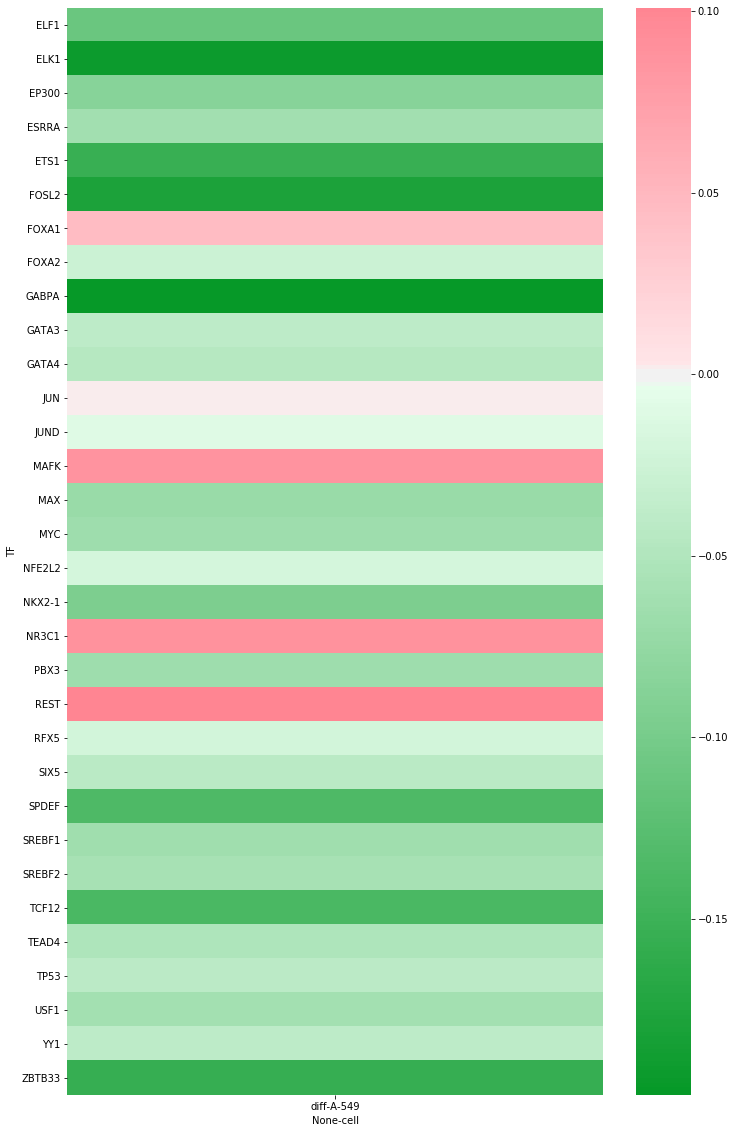

In [457]:
aurocs=pd.DataFrame(table)
aurocs.columns=['cell','TF','pwm_auroc','wgbs_auroc','pwm_aupr','wgbs_aupr','pwm_mcc','wgbs_mcc']
# aurocs['diff']=aurocs['pwm_auroc']-aurocs['wgbs_auroc']
# aurocs['diff']=aurocs['pwm_aupr']-aurocs['wgbs_aupr']
aurocs['diff']=aurocs['pwm_mcc']-aurocs['wgbs_mcc']
del aurocs['pwm_auroc'], aurocs['wgbs_auroc'],aurocs['pwm_aupr'],aurocs['wgbs_aupr'],aurocs['pwm_mcc'],aurocs['wgbs_mcc']
heat=aurocs.pivot_table(index=['TF'], columns='cell')
plt.figure(figsize=(12, 20))
# plt.imshow(heat, cmap='hot', interpolation='nearest')
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
ax= sns.heatmap(heat, center=0,cmap=rdgn)
# plt.show
plt.savefig("output.png",dpi=300)

### add non-CpG motif back to wgbs-based motif

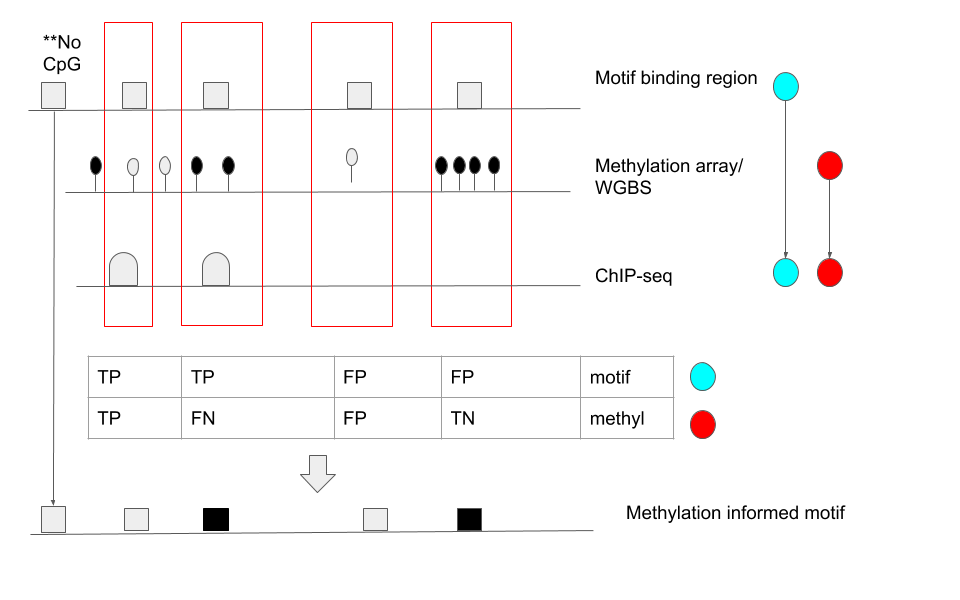

In [43]:
Image(filename='../../../analyses/MILIPEED/expanded_link_calling.png')

(array([604., 226.,  69.,  39.,  18.,  25.,  38.,  88., 231., 590.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

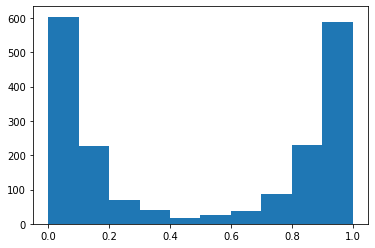

In [456]:
down=np.floor(len(data.array)/2)
up=np.ceil(len(data.array)/2)
x=1-(np.random.pareto(10, down.astype(int))+ 0)
y=(np.random.pareto(10, up.astype(int))+ 0)

z=np.concatenate((x,y),axis=None)
z[z>1]=1
z[z<0]=0
# j=len(data.array)-len(z)

plt.hist(z)

In [266]:
traces= glob.glob('data/MotifPipeline/MeArrayIntersectFULL/*')
data=pd.read_csv(traces[1],sep='\t',na_values='NaN',names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF",'mec','mes','mee','array'])   
data.ChIPTF=data.ChIPTF.replace('.','0')
data.ChIPTF=pd.to_numeric(data.ChIPTF)
data2=data.copy()
data3=data.copy()
data=data[data['weight']!=data['wgbs']]
del data['gene']#,data['ChIPTF'],data['mec'],data['mes'],data['mee'],data['array']
data=data.drop_duplicates()
ff=data.groupby([data.chr,data.start,data.end,data.weight,data.wgbs]).size().reset_index(name='counts')

data2=data2[data2['weight']!=data2['array']]
del data2['gene']#,data2['ChIPTF'],data2['mec'],data2['mes'],data2['mee'],data2['wgbs']

data2=data2.drop_duplicates()
gg=data2.groupby([data2.chr,data2.start,data2.end,data2.weight,data2.array]).size().reset_index(name='counts')


# data3=data3[data3['weight']!=data3['wgbs']]
# data3=data3[data3['weight']!=data3['array']]
# del data3['gene']
# data3=data3.drop_duplicates()
# hh=data3.groupby([data3.chr,data3.start,data3.end,data3.weight]).size().reset_index(name='counts')


[ff.shape,gg.shape]

[(181092, 6), (3466, 6)]

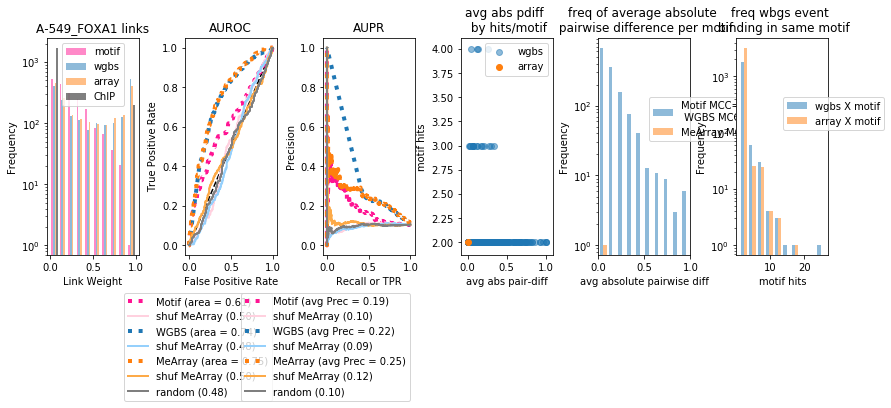

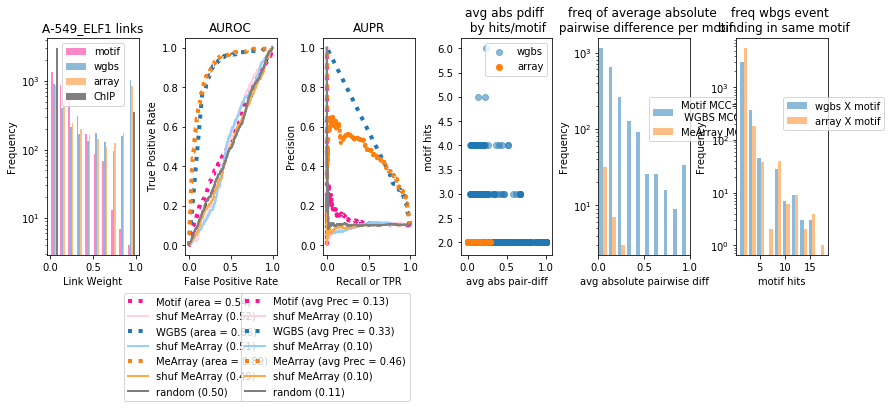

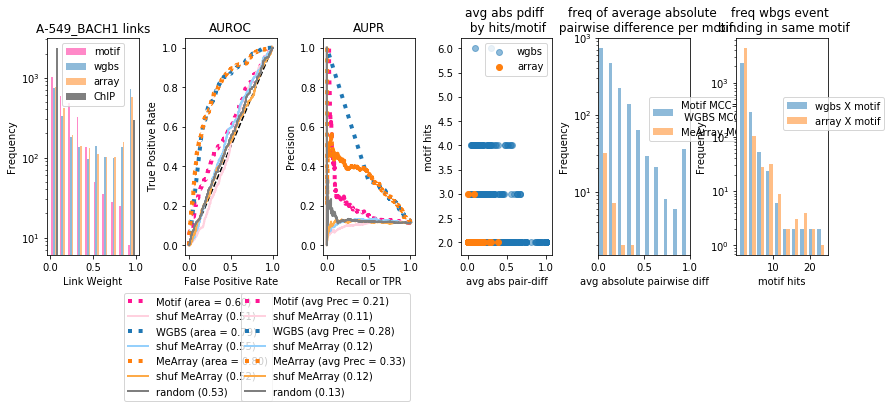

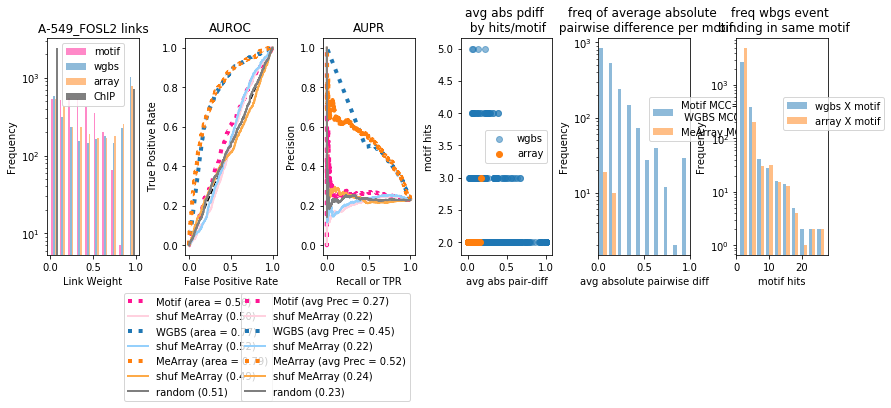

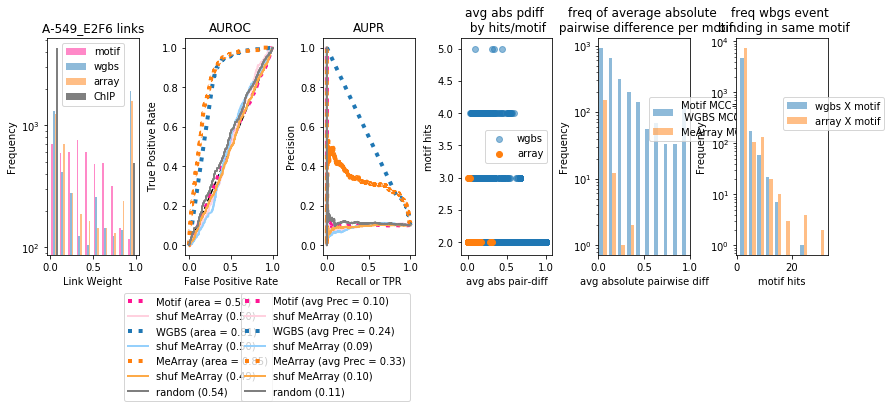

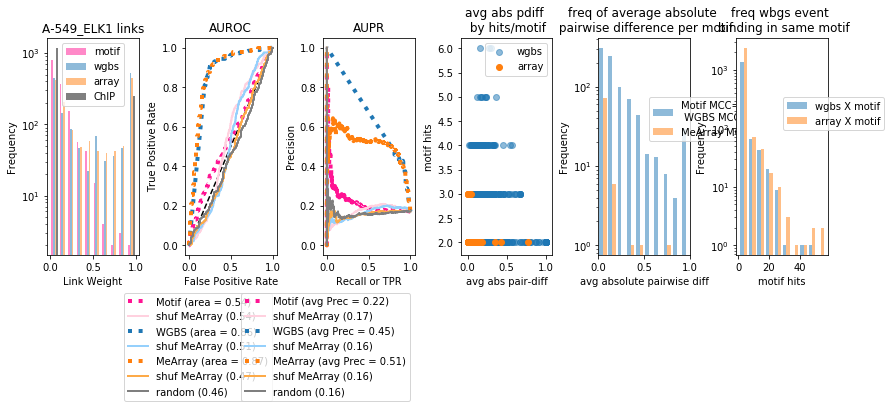

KeyboardInterrupt: 

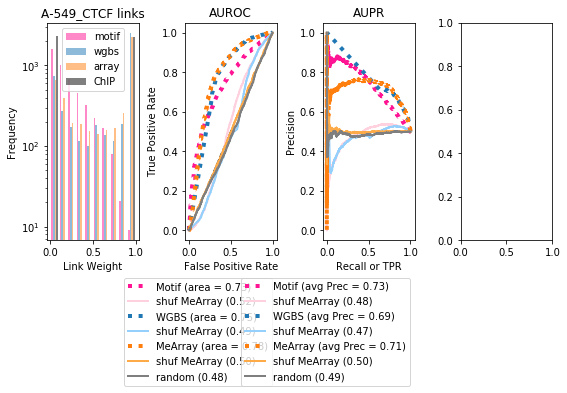

In [421]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# import matplotlib.backends.backend_pdf
table=[]

# path='../validate_milipeed'
# traces= glob.glob('/udd/redmo/data/MotifPipeline/validate_milipeed/*')
# traces= glob.glob('data/MotifPipeline/val_mili_plusNONcpg/*')
traces= glob.glob('data/MotifPipeline/MeArrayIntersectFULLshuf/*')

WWW=6
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

for j,trace in enumerate(traces):
    table2=[]
    tbl=[]
    tmpTBL2=[]
    tmpTBL=[]
#     filepath = os.path.join(path, trace)
#     data=pd.read_csv(filepath,sep='\t',usecols=[0,1,2,3,7,8,16,20,21],names=["chrMotif", "MSS", "MES",'pwm','WSS','WES',"wgbs",'gene',"ChIPTF"]) 
    data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,5,6,7,8,12,13],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF",'shW','shWG','array','shA']) 

# Refit data to 0-1    
    data.ChIPTF=data.ChIPTF.replace('.','0')
#     data=data[data.ChIPTF!='.']
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
#     if data.wgbs==data.weight:
#         data.wgbs=1
#     else:
#         data.wgbs=1-(data.wgbs)

#     data=data[data.wgbs<=100]
#     data['weight']=((data.pwm-min(data.pwm))/(max(data.pwm)-min(data.pwm)))
#     data.wgbs=1-(data.wgbs) ##intersect script returns binding score already
#     data.weight=1 ## test with PWM=1 -- all AUROC =.5
#     data=data[(data[])]
#     data3=data.copy()
    data=data[data['weight']!=data['wgbs']] ##subset of motif or entire motif flag
    data=data[data['weight']!=data['array']] ##subset of motif or entire motif flag
    
#     data['array']=1-data['array']
    data['array'] = np.where(data['weight'] == data['array'], data['array'],1-data['array'])
    
    data4=data.copy()
##examining mearray repeats indicates multiple wgbs events 
    data2=data.copy()
    del data2['ChIPTF'],data2['gene']
    data2=data2[data2['weight']!=data2['array']]
    data2=data2.drop_duplicates()
    df2=data.groupby([data2.chr,data2.start,data2.end,data2.weight,data2.array]).size().reset_index(name='counts')
##examining wgbs repeats indicates multiple mearray events 
    data3=data.copy()
    del data3['ChIPTF'],data3['gene']
    data3=data3[data3['weight']!=data3['wgbs']]
    data3=data3.drop_duplicates()
    df3=data.groupby([data3.chr,data3.start,data3.end,data3.weight,data3.wgbs]).size().reset_index(name='counts')

    df=data.groupby([data.chr,data.start,data.end]).size().reset_index(name='counts')
#     data = data.groupby([data.chr,data.start,data.end]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean',"array":'first'})
    data = data.groupby([data.chr,data.start,data.end]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean',"array":'first','shW':"mean",'shWG':'mean','shA':'mean'})

    data=data.merge(df,on=['chr','start','end'])
#     df=data.groupby([data.chrMotif,data.MSS,data.MES]).size().reset_index(name='counts')
#     data = data.groupby([data.chrMotif,data.MSS,data.MES]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean'})
#     data=data.merge(df,on=['chrMotif','MSS','MES'])
    ##make random bimodal distribution for comparison
    down=np.floor(len(data.array)/2)
    up=np.ceil(len(data.array)/2)
    x=1-(np.random.pareto(10, down.astype(int))+ 0)
    y=(np.random.pareto(10, up.astype(int))+ 0)
    z=np.concatenate((x,y),axis=None)
    z[z>1]=1
    z[z<0]=0
    
    f= plt.figure(figsize=(14, 4))
## Plot all three value distributions fit to same 0-1 scale
    plt.subplot(1, WWW, 1)
    colors = ['motif','wgbs','array','ChIP']
    plt.hist([pd.to_numeric(data['weight']),pd.to_numeric(data['wgbs']),pd.to_numeric(data['array']),pd.to_numeric(data['ChIPTF'])],alpha=.5,log=True,stacked=False,label=colors,color=['deeppink','tab:blue','tab:orange','k'])
    plt.legend(loc="upper center")
    plt.xlabel('Link Weight')
    plt.ylabel('Frequency')
    plt.title(''+trace.split('/')[3]+' links')

## Plot scatter of WGBS and motif to ChIP
#     plt.subplot(1, 5, 2)
#     sns.scatterplot(data.wgbs,data.ChIPTF,label='wgbs',alpha=.5)
#     sns.scatterplot(data.weight,data.ChIPTF,label='motif',alpha=.5,color='deeppink').set_title("ChIP vs Motif & wgbs")

## Plot all ROC curves
###PWM
    
    plt.subplot(1, WWW, 2)
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.weight)
    roc_auc=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='Motif (area = {0:0.2f})'
                   ''.format(roc_auc),
             color='deeppink', linestyle=':', linewidth=4)
    
#     rpwma=np.random.permutation(data.weight)
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF,data.shW)
    rand_pwm_auroc=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_pwm_auroc),
             color='xkcd:light pink', linestyle='-', linewidth=2)
###WGBS
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.wgbs)
    roc_auc2=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='WGBS (area = {0:0.2f})'
                   ''.format(roc_auc2),
             color='tab:blue', linestyle=':', linewidth=4)
    
#     rwgbsa=np.random.permutation(data.wgbs)
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.shWG)
    rand_wgbs_auroc=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_wgbs_auroc),
             color='xkcd:light blue', linestyle='-', linewidth=2)
    
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.array)
    roc_auc5=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='MeArray (area = {0:0.2f})'
                   ''.format(roc_auc5),
             color='tab:orange', linestyle=':', linewidth=4)
    
#     rarray=np.random.permutation(data.array)
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.shA)
    rand_arr_auroc=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_arr_auroc),
             color='xkcd:light orange', linestyle='-', linewidth=2)
    
    fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, z)
    rra=metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label='random ({0:0.2f})'
                   ''.format(rra),
             color='tab:grey', linestyle='-', linewidth=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC')
    plt.legend(loc="bottom",bbox_to_anchor=(1, -.15))
    plt.subplots_adjust(wspace=.5)

## Overlap of link calls
#     fig=plt.subplot(1, 5, 4)
#     labels = ['TPTP','FPFP','FNFN','TNTN','TPFN','FNTP','FPTN','TNFP']
#     pwm = [
#         len(data[(data.weight>.5)&(data.ChIPTF>.5)&data.wgbs>.5]),
#         len(data[(data.weight>.5)&(data.ChIPTF<.5)&data.wgbs>.5]),    
#         len(data[(data.weight<.5)&(data.ChIPTF>.5)&data.wgbs<.5]),
#         len(data[(data.weight<.5)&(data.ChIPTF<.5)&data.wgbs<.5]),
#         len(data[(data.weight>.5)&(data.ChIPTF>.5)&data.wgbs<.5]),
#         len(data[(data.weight<.5)&(data.ChIPTF>.5)&data.wgbs>.5]),
#         len(data[(data.weight>.5)&(data.ChIPTF<.5)&data.wgbs<.5]), 
#         len(data[(data.weight<.5)&(data.ChIPTF<.5)&data.wgbs>.5])]

#     x = np.arange(len(labels))
#     width = 0.35
#     PWM=plt.bar(x ,np.round(np.log(pwm),decimals=4),width,label='scores',color='tab:blue')
#     plt.xticks(x,labels,rotation=90)
#     plt.ylabel('log count')
#     plt.title('matched links \n motif then wgbs')

    plt.subplot(1, WWW, 3)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.weight)
    roc_auc3=metrics.average_precision_score(data.ChIPTF, data.weight)
    plt.plot(recall,precision, 
             label='Motif (avg Prec = {0:0.2f})'
                   ''.format(roc_auc3),
             color='deeppink', linestyle=':', linewidth=4)
#     rpwmp=np.random.permutation(data.weight)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.shW)
    rand_pwm_aupr=metrics.average_precision_score(data.ChIPTF, data.shW)
    plt.plot(recall,precision, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_pwm_aupr),
             color='xkcd:light pink', linestyle='-', linewidth=2)
    
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.wgbs)
    roc_auc4=metrics.average_precision_score(data.ChIPTF, data.wgbs)
    plt.plot(recall,precision, 
             label='WGBS (avg Prec = {0:0.2f})'
                   ''.format(roc_auc4),
             color='tab:blue', linestyle=':', linewidth=4)
#     rwgp=np.random.permutation(data.wgbs)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.shWG)
    rand_wgbs_aupr=metrics.average_precision_score(data.ChIPTF, data.shWG)
    plt.plot(recall,precision, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_wgbs_aupr),
             color='xkcd:light blue', linestyle='-', linewidth=2)
    
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.array)
    roc_auc6=metrics.average_precision_score(data.ChIPTF, data.array)
    plt.plot(recall,precision, 
             label='MeArray (avg Prec = {0:0.2f})'
                   ''.format(roc_auc6),
             color='tab:orange', linestyle=':', linewidth=4)
#     rmep=np.random.permutation(data.array)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, data.shA)
    rand_me_aupr=metrics.average_precision_score(data.ChIPTF, data.shA)
    plt.plot(recall,precision, 
             label='shuf MeArray ({0:0.2f})'
                   ''.format(rand_me_aupr),
             color='xkcd:light orange', linestyle='-', linewidth=2)
    
#     randrand=np.random.rand(data.array)
    precision, recall, thresholds = metrics.precision_recall_curve(data.ChIPTF, z)
    rr=metrics.average_precision_score(data.ChIPTF, z)
    plt.plot(recall,precision, 
             label='random ({0:0.2f})'
                   ''.format(rr),
             color='tab:grey', linestyle='-', linewidth=2)

#     plt.plot([1, 0], [0, 1], 'k--')
    plt.xlabel('Recall or TPR')
    plt.ylabel('Precision')
    plt.title('AUPR')
    plt.legend(loc="bottom",bbox_to_anchor=(1, -.15))
    plt.subplots_adjust(wspace=.5)
    
    plt.subplot(1, WWW, 4)
    j=np.where(np.array(data.ChIPTF).reshape(1,-1)>.5,1,0)
    z=np.where(np.array(data.weight).reshape(1,-1)>.5,1,0)
    mcm = metrics.confusion_matrix(j.ravel(),z.ravel())
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]
    mcc1= np.divide((tp* tn - fp * fn), np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

#     jj=np.where(np.array(data.ChIPTF).reshape(1,-1)>.5,1,0)
    zz=np.where(np.array(data.wgbs).reshape(1,-1)>.5,1,0)
    mcm2 = metrics.confusion_matrix(j.ravel(),zz.ravel())
    tn2 = mcm2[0, 0]
    tp2 = mcm2[1, 1]
    fn2 = mcm2[1, 0]
    fp2 = mcm2[0, 1]
    mcc2= np.divide((tp2* tn2 - fp2 * fn2), np.sqrt((tp2+fp2)*(tp2+fn2)*(tn2+fp2)*(tn2+fn2)))
    
#     jjj=np.where(np.array(data.array).reshape(1,-1)>.5,1,0)
    zzz=np.where(np.array(data.array).reshape(1,-1)>.5,1,0)
    mcm3 = metrics.confusion_matrix(j.ravel(),zzz.ravel())
    tn3 = mcm3[0, 0]
    tp3 = mcm3[1, 1]
    fn3 = mcm3[1, 0]
    fp3 = mcm3[0, 1]
    mcc3= np.divide((tp3* tn3 - fp3 * fn3), np.sqrt((tp3+fp3)*(tp3+fn3)*(tn3+fp3)*(tn3+fn3)))
    
#     data33=data3.merge(df3,on=['chr','start','end','weight','wgbs'])
#     data22=data2.merge(df2,on=['chr','start','end','weight','array'])
    
    for jj,start in enumerate(data.start):
        zz=df3[df3['start']==start]
        if zz.count!=1:
            yy=[np.abs(x - y) for i,x in enumerate(zz.wgbs) for j,y in enumerate(zz.wgbs) if i != j]
#     for jj,start in enumerate(data33.start):
        zzz=df2[df2['start']==start]
        if zzz.count!=1:
            yyy=[np.abs(x - y) for i,x in enumerate(zzz.array) for j,y in enumerate(zzz.array) if i != j]

        table2.append(np.mean(yy))
        tmpTBL2.append(len(zz))#/np.math.factorial(len(yy)))
        tbl.append(np.mean(yyy))
        tmpTBL.append(len(zzz))#/np.math.factorial(len(yyy)))
    colors = ['wgbs X motif','array X motif']
    plt.scatter(table2,tmpTBL2,alpha=.5,label='wgbs',color=['tab:blue'])
    plt.scatter(tbl,tmpTBL,alpha=1,label='array',color=['tab:orange'])
    plt.legend(loc="best")#,bbox_to_anchor=(0.45, .75))
    plt.xlabel('avg abs pair-diff')
    plt.ylabel('motif hits')
    plt.title('avg abs pdiff \n by hits/motif')
    
    if WWW==5 or WWW==6:
        plt.subplot(1, WWW, 5)

        try:
            colors = ['Motif MCC= %.3e \n WGBS MCC= %.3e' % (mcc1,mcc2), 'MeArray MCC= %.3e' % mcc3]
            plt.hist([table2,tbl],alpha=.5,log=True,stacked=False,label=colors,color=['tab:blue','tab:orange'])

            plt.legend(loc="bottom",bbox_to_anchor=(0.5, .5))
            plt.xlim(0,1)
            plt.xlabel('avg absolute pairwise diff')
            plt.ylabel('Frequency')
            plt.title('freq of average absolute \n pairwise difference per motif')
        except ValueError:
            pass
    if WWW==6:
        plt.subplot(1, WWW, 6)

    #     plt.hist(df2.counts,alpha=1,log=True,stacked=True,density=True,label='motif X wgbs',color=['deeppink'])
    #     plt.hist(df3.counts,alpha=.25,log=True,stacked=True,density=True,label='motif X mearray',color=['tab:orange'])

        colors = ['wgbs X motif','array X motif']
        plt.hist([df2.counts,df3.counts],alpha=.5,log=True,stacked=False,label=colors,color=['tab:blue','tab:orange'])
    #     plt.legend(loc="upper center")

        plt.legend(loc="bottom",bbox_to_anchor=(0.45, .75))
        plt.xlabel('motif hits')
        plt.ylabel('Frequency')
        plt.title('freq wbgs event \n binding in same motif')
    

    
    plt.show()
    
#     Col1=trace.split('/')[3]
    Col1=os.path.basename(trace).split('_')[0] #TF
    Col2=os.path.basename(trace).split('_')[1] #gene
#     Col=trace.split('/')[6]
#     Col1=Col.split('_')[0]
#     Col2=Col.split('_')[1] 
    
    Col3=roc_auc #motif auroc
    Col4=roc_auc2 #wgbs auroc
    Col5=roc_auc3 #motif aupr
    Col6=roc_auc4 #wgbs aupr
    Col10=roc_auc5 #mearray auroc
    Col11=roc_auc6 #mearray aupr
    Col7=mcc1 #motif mcc
    Col8=mcc2 #wgbs mcc
    Col12=mcc3 #mearray mcc
    Col9=np.nanmean(table2)
    Col13=np.nanmean(tbl)
    Col14=np.nanmean(tmpTBL2)
    Col15=np.nanmean(tmpTBL)
    column = Col1, Col2, Col3, Col4, Col10, Col5, Col6, Col11,Col7,Col8,Col12,Col9,Col13,Col14,Col15
    table.append(column)
#     table3.append(np.mean(table2))
    plt.show()
# for fig in range(1, plt.gcf().number + 1):
#     pdf.savefig( fig )
# pdf.close()

In [256]:
# table=[]
traces=glob.glob('/udd/redmo/netZooPy/tests/milipeed/ToyData/SK-N-SH*')

data=pd.read_csv(traces[0],sep='\t',usecols=[0,1,2,5,6,11,12],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF"]) 
data.ChIPTF=data.ChIPTF.replace('.','0')
data.ChIPTF=pd.to_numeric(data.ChIPTF)
data2=data[data.ChIPTF!=0]
data2['TF']=os.path.basename(trace).split('_')[1]
data2=data2[['TF','gene','weight','wgbs','ChIPTF']]

for j,trace in enumerate(traces):
    data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,5,6,11,12],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF"]) 
    data.ChIPTF=data.ChIPTF.replace('.','0')
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
    data3=data[data.ChIPTF!=0]
    data3['TF']=os.path.basename(trace).split('_')[1]
    data3=data3[['TF','gene','weight','wgbs','ChIPTF']]
    
    data2=pd.concat([data2,data3],ignore_index=True)
df=pd.DataFrame(data2,columns=['TF','gene','weight','wgbs','ChIPTF'])
df.to_csv('/udd/redmo/netZooPy/tests/milipeed/ToyData/SKNSH_methyl_test.txt',sep='\t',index=False)



/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [419]:
data

,chr,start,end,weight,wgbs,ChIPTF,array,counts
0,chr1,765422,765436,0.122384,0.03,0,0.216949,2
1,chr1,898791,898805,0.223820,0.00,0,0.126186,2
2,chr1,1338316,1338330,0.029768,0.00,0,0.062557,2
3,chr1,1421347,1421361,0.661526,0.00,1,0.074782,2
4,chr1,1985442,1985456,0.116873,0.00,0,0.194295,2
...,...,...,...,...,...,...,...,...
1923,chrX,152959697,152959711,0.008820,0.67,0,0.841461,2
1924,chrX,154332164,154332178,0.665934,0.29,0,0.290050,2
1925,chrX,155133823,155133837,0.130098,1.00,0,0.952732,2
1926,chrY,2934848,2934862,0.728776,1.00,1,0.909338,4


In [50]:
# table=pd.DataFrame(columns=['link'])
traces=glob.glob('/udd/redmo/netZooPy/tests/milipeed/ToyData/archive/*methyl_test.txt')

# data=pd.read_csv(traces[0],sep='\t',header=0,names=['TF','gene',os.path.basename(traces[0].split('_')[0])+'weight',os.path.basename(traces[0].split('_')[0])+'wgbs',os.path.basename(traces[0].split('_')[0])+'ChIPTF'])
# data.index=data.TF+'_'+data.gene
# del data['TF'], data['gene']

for j,trace in enumerate(traces):
    data2=pd.read_csv(trace,sep='\t',header=0,names=['TF','gene',os.path.basename(trace.split('_')[0])+'_weight',os.path.basename(trace.split('_')[0])+'_wgbs',os.path.basename(trace.split('_')[0])+'_ChIPTF'])
    data2['link']=data2.TF+'_'+data2.gene
    del data2['TF'], data2['gene']
    data2=data2.sort_values('link')
#     table=table.join(data2)
    data3=data2.groupby('link', as_index=False).mean()
    if j==0:
        table=pd.DataFrame(data3)
    else:
#         append_data=pd.concat([append_data,pd.DataFrame(data.value)],axis=1)
        table=table.merge(data3,on='link',how='inner')
#         table=pd.merge(table,data2,left_index=True,right_index=True)
table.to_csv('/udd/redmo/netZooPy/tests/milipeed/ToyData/ENCODE_5cell_pwm_wgbs_chip.txt',sep='\t',index=False)



<function matplotlib.pyplot.show(*args, **kw)>

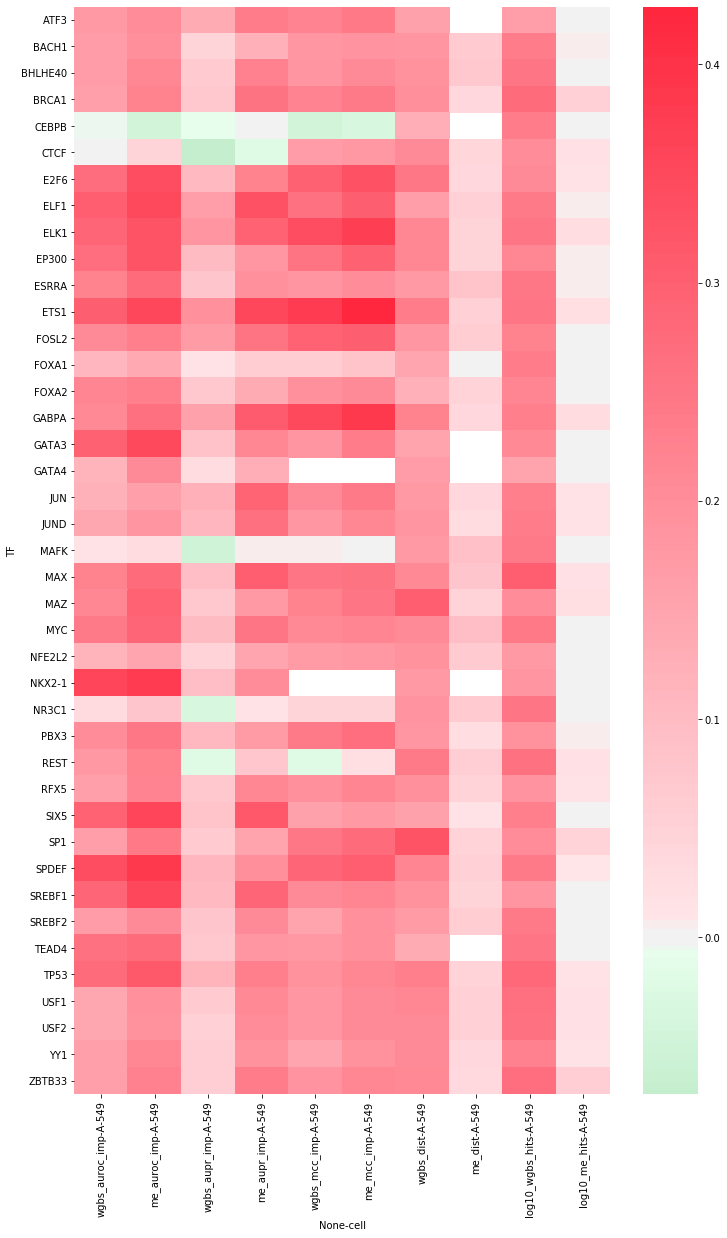

In [417]:
table2=table
aurocs=pd.DataFrame(table)
aurocs.columns=['cell','TF','mo_auroc','wgbs_auroc','me_auroc','mo_aupr','wgbs_aupr','me_aupr','mo_mcc','wgbs_mcc','me_mcc','wgbs_dist','me_dist','wgbs_hits','me_hits']
aurocs['wgbs_auroc_imp']=aurocs['wgbs_auroc']-aurocs['mo_auroc']
aurocs['me_auroc_imp']=aurocs['me_auroc']-aurocs['mo_auroc']
aurocs['wgbs_aupr_imp']=aurocs['wgbs_aupr']-aurocs['mo_aupr']
aurocs['me_aupr_imp']=aurocs['me_aupr']-aurocs['mo_aupr']
aurocs['wgbs_mcc_imp']=aurocs['wgbs_mcc']-aurocs['mo_mcc']
aurocs['me_mcc_imp']=aurocs['me_mcc']-aurocs['mo_mcc']
aurocs['log10_wgbs_hits']=np.log10(aurocs['wgbs_hits'])
aurocs['log10_me_hits']=np.log10(aurocs['me_hits'])


aurocs.drop(['mo_auroc','wgbs_auroc','me_auroc','mo_aupr','wgbs_aupr','me_aupr','mo_mcc','wgbs_mcc','me_mcc'],axis=1,inplace=True)
heat=aurocs.pivot_table(index=['TF'], columns='cell')
heat=heat[['wgbs_auroc_imp','me_auroc_imp','wgbs_aupr_imp','me_aupr_imp','wgbs_mcc_imp','me_mcc_imp','wgbs_dist','me_dist','log10_wgbs_hits','log10_me_hits']]

plt.figure(figsize=(12, 20))
# plt.imshow(heat, cmap='hot', interpolation='nearest')
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
ax= sns.heatmap(heat, center=0,cmap=rdgn)
plt.show
# plt.savefig("NONcpg_output.png",dpi=300)

### copy motif line names to hg38 FROM hg19

In [ ]:
%%bash
Ndir='/udd/redmo/data/MotifPipeline/hg19_refseq_100kb_tr'
Tdir='/udd/redmo/data/MotifPipeline/hg38_refseq_100kb_tr_fromhg19'
Tfiles=$(ls $Tdir/*.txt)
Ttrdir='/udd/redmo/data/MotifPipeline/hg38_refseq_100kb_trFROMhg19'
# mkdir $Ttrfiles
# echo $Tfiles
for tfile in $Tfiles
do
paste $tfile $Ndir/`basename $tfile` | cut -f1,2,3,4,12 > $Ttrdir/`basename $tfile`
# echo `dirname "$tfile"`
# echo `basename "$tfile"`
done

## patient age MILIPEED net analysis

### GLM function

In [ ]:
def LM(DEE,gene):
    DEE[gene]=pd.to_numeric(DEE[gene])
    fmla = (gene+"~ age+ PY+ FEV+sex")
    model = sm.formula.glm(fmla, family=sm.families.Gaussian(),data=DEE).fit()
    results=pd.DataFrame(results_summary_to_dataframe(model,gene))  
    return results

In [ ]:
def results_summary_to_dataframe(results,gene):
    pvals = results.tvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]
    results_df = pd.DataFrame({gene+"pvals":pvals,gene+"coeff":coeff,})
    results_df = results_df[[gene+"coeff",gene+"pvals"]]
    return results_df

In [ ]:
## compute distinct links per age per set of MILIPEED LTCOPD nets
set='milipeed'
# control = pd.read_csv('/udd/redmo/analyses/MILIPEED/control.txt',sep=',',header=0 ,usecols=['number','age.x','FEV1FVC.x','sex.x','BMI.x','packyears.x','sapphire'])
# control.columns=['iden','no','age','sex','bmi','FEV','PY']
# control['ID']=(control['iden'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_2']
# control.sort_values(by='ID',ascending=False)
# del control['iden']

# case = pd.read_csv('/udd/redmo/analyses/MILIPEED/case.txt',sep=',',header=0 ,usecols=['number','age.x','FEV1FVC.x','sex.x','BMI.x','packyears.x','sapphire'])
# case.columns=['iden','no','age','sex','bmi','FEV','PY']
# case['ID']=(case['iden'].str.split('-', expand=True).rename(columns=lambda x: f"string_{x+1}"))['string_2']
# case.sort_values(by='ID',ascending=False)
# del case['iden']
# EE = control.append(pd.DataFrame(data = case), ignore_index=True)
# EE
metadata = pd.read_csv('/udd/redmo/analyses/MILIPEED/subj_metadata.txt',sep='\t',header=0)
metadata.columns=['ID','age','sex','BMI','FEV','PY']
metadata['COPD'] = np.where(metadata['FEV']>.7, 'COPD', 'NO')
metadata['age_range'] = np.where(metadata['age']<50, 'fourties', np.where(metadata['age']<60,
        'fifties',np.where(metadata['age']<70,'sixties',np.where(metadata['age']<80,'seventies','eighties'))))
metadata.set_index('ID', inplace=True)

In [ ]:
metadata

In [ ]:
# names1 = [os.path.basename(x) for x in glob.glob('/udd/redmo/analyses/MILIPEED/' + set +'_control/*.pairs')]
# names2 = [os.path.basename(x) for x in glob.glob('/udd/redmo/analyses/MILIPEED/' + set +'_case/*.pairs')]
# names=names1+names2
# j=[i.split('-', 1)[1] for i in names]
# names=[i.split('_', 1)[0] for i in j]


# EE=EE.reindex(names)

In [ ]:
# %%bash
# cut -f4 /udd/redmo/analyses/MILIPEED/eye_control*.pairs | paste > eco_results.txt
# cut -f4 /udd/redmo/analyses/MILIPEED/eye_case*.pairs | paste > eca_results.txt

In [ ]:
##REAL SCRIPT will look at case and control, here for memory issues we just duplicate control and constrain to first 78

r=pd.read_csv('/udd/redmo/analyses/MILIPEED/zero_control/zero_ST-01016307_FinalNetwork.pairs',usecols=[0,1],sep='\t')
r.columns=['TF','gene']
control = pd.read_csv('/udd/redmo/analyses/MILIPEED/'+set+'_control/results.txt',sep='\t',header=0)
# case = pd.read_csv('/udd/redmo/analyses/MILIPEED/'+set+'_case/results.txt',sep='\t',header=0)
JJ = pd.concat([r.TF,r.gene,control, control], axis=1)
del control

In [ ]:
COPD_GWAS_genes = pd.read_csv("/udd/redmo/analyses/MILIPEED/COPD_GWAS_genes.csv",usecols=[0])
gwasTF=JJ[JJ['TF'].isin(COPD_GWAS_genes.closest_gene)]
gwasgene=JJ[JJ['gene'].isin(COPD_GWAS_genes.closest_gene)]
gwasONLY=gwasTF[gwasTF['gene'].isin(COPD_GWAS_genes.closest_gene)]
csv=gwasgene
links=gwasgene.TF+'_'+gwasgene.gene
# link=links.replace('-','_')
DDD=csv.transpose()
DDD.columns=links
DDD=DDD.drop(DDD.index[0:2])
DEE = np.concatenate([EE[0:78],DDD], axis=1)
DEE=pd.DataFrame(DEE)
DEE.columns=(EE[0:78].join(DDD)).columns ## remove 0:78 when full population can be run
DEE.index=EE[0:78].index
DEE.age=pd.to_numeric(DEE.age)
DEE=DEE.round({'age':0})
DEE['FEV']=pd.to_numeric(DEE['FEV'])
DEE['PY']=pd.to_numeric(DEE['PY'])
DEE['age']=DEE['age'].astype(object)

In [ ]:
# gene=DEE.columns[8]
# results=LM(DEE,gene)
# results.T.to_csv(('/udd/redmo/analyses/MILIPEED/MILI_'+set+'_indv_'+ccc+".txt"),sep='\t')
# for gene in DEE.columns[8:DEE.shape[1]]:
#     results=LM(DEE,gene)
#     results.T.to_csv(('/udd/redmo/analyses/MILIPEED/MILI_'+set+'_indv_'+ccc+".txt"),sep='\t')
#     print(gene)

In [ ]:
# %%bash
# cut -f1 --delimiter=',' /udd/redmo/analyses/MILIPEED/COPD_GWAS_genes.csv > /udd/redmo/analyses/MILIPEED/COPD_GWAS_genes1.csv


In [ ]:
from datetime import datetime, date
ccc="{:%d.%m.%Y}".format(datetime.now())

### read in processed output

In [ ]:
links = pd.read_csv('/udd/redmo/analyses/MILIPEED/MILI_milipeed_indv_24.02.2020.txt',sep='\t',header=0,index_col=0)
mc=links[links.index.str.contains('coeff')]
mp=links[links.index.str.contains('pval')]

In [ ]:
# cc=str(mp[(np.abs(mp.Intercept))<.05].index).replace('pvals','coeff')
s=mp[(np.abs(mp['sex[T.M]']))<.05].index
ss=[w.replace('pvals', 'coeff') for w in s]
male=mc[mc.index.isin(ss)]

In [ ]:
male=male.T
g=male.index
ss=[w.replace('age[T.', '') for w in g]
sss=[w.replace('.0]', '') for w in ss]
male.index=sss
male['source'], male['target'] = male.index.str.split('_',1).str
male.target=[w.replace('coeff', '') for w in male.target]
male=male.T

In [ ]:
sns.set_style('whitegrid')
sns.mpl.rc('figure',figsize=(16, 6))
fig, ax = plt.subplots()
for i in male.columns:
    ax.plot(male.index[1:len(male.index)-5],male[i][1:len(male.index)-5],label=str(i))
    ax.set_title('Link Weight change per age')
#     ax.legend(i)
    ax.xaxis.set_label_text('Age')
    ax.yaxis.set_label_text('Link Weight')
plt.show()
# plotly_fig = tls.mpl_to_plotly(fig)
# pio.show(plotly_fig)

# Time Series Network Analysis

In [ ]:
male=male.T
male44=nx.from_pandas_edgelist(male, source='source', target='target', edge_attr='44')

COPD_GWAS_genes = pd.read_csv("/udd/redmo/analyses/MILIPEED/COPD_GWAS_genes.csv",usecols=[0])
degree_sequence = sorted([d for n, d in male44.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Male 44yo LTCOPD MILIPEED network")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = male44.subgraph(sorted(nx.connected_components(male44), key=len, reverse=True)[0])
# pos = nx.spring_layout(G4)
pos = nx.draw_circular(male44)#,prior4.source)
plt.axis('off')
nx.draw_networkx(male44, pos=pos, font_size=4, node_color='blue',node_size=300, font_color='white',edge_color='black')
nx.draw_networkx(male44.subgraph(COPD_GWAS_genes.closest_gene), pos=pos, font_size=14,node_size=400, node_color='red', font_color='black')

# nx.draw_networkx_nodes(G4, pos, node_size=20)
# nx.draw_networkx_edges(G4, pos, alpha=0.4)

plt.show()

In [ ]:
import chart_studio.plotly as py
from plotly.graph_objs import *
import plotly.io as pio
import networkx as nx

In [ ]:
E=male44.edges
N=list(male44.nodes)
V=range(len(N))

g=nx.Graph()
g.add_nodes_from(V)
g.add_edges_from(E)# E is the list of edges

pos=nx.fruchterman_reingold_layout(g)

In [ ]:
Xv=[pos[k][0] for k in range(len(N))]
Yv=[pos[k][1] for k in range(len(N))]
Xed=[]
Yed=[]
for edge in E:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None]

trace3=Scatter(x=Xed,y=Yed,mode='lines',line=dict(color='rgb(210,210,210)', width=1),hoverinfo='none')
trace4=Scatter(x=Xed,y=Yed,mode='markers',name='net',marker=dict(symbol='circle-dot',size=5,color='#6959CD',line=dict(color='rgb(50,50,50)', width=0.5)),text=N,hoverinfo='text')
axis=dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,title='')
layout=Layout(font= dict(size=12),showlegend=False,autosize=True,width=800,height=800,
              xaxis=axis,yaxis=axis)#,annotations=[dict(showarrow=True)])
data1=[trace3, trace4]
fig1=Figure(data=data1, layout=layout)
pio.show(fig1)

In [ ]:
# mod = AutoReg(endog=housing.AHR_ADAM19, 3, exog=[housing.FEV,housing.PY,housing.age])
mod = AutoReg(data3.AHR_ADAM19, 3,exog=data3.age)
res = mod.fit()
res.summary()

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig)

In [ ]:
data2=DEE[['age','FEV','PY','AHR_ADAM19']]
data2['AHR_ADAM19']=pd.to_numeric(data2['AHR_ADAM19'])
data2['age']=data2['age'].astype(object)
# da,DEE.FEV,DEE.PY]
# data2.reindex('age')
plt.hist(data2['age'],bins=80)
plt.show()

In [ ]:
data3=data2.groupby('age', as_index=False)['FEV','PY','AHR_ADAM19'].mean()

# Network Analysis/ Display

In [ ]:
[list(G4.subgraph(genes.closest_gene)),
list(G5.subgraph(genes.closest_gene)),
list(G6.subgraph(genes.closest_gene)),
list(G7.subgraph(genes.closest_gene))]

In [ ]:
Q=G7.subgraph(G4.nodes)
QQ=G4.subgraph(G7.nodes)
# QQ.nodes==Q.nodes
# bb=nx.disjoint_union(Q,QQ)
# cc=nx.intersection(Q,QQ)
dd=nx.difference(Q,QQ)
ee=nx.difference(QQ,Q)
eee=nx.symmetric_difference(QQ,Q)

### low memory

In [ ]:
a = np.random.rand(10,10)
# np.dot(a.T, a)
b=np.tril(a)
c=np.tril(a) + b.T

In [ ]:
cc=sparse.csr_matrix(c).multiply(sparse.csr_matrix(a)).todense()

In [ ]:
d=sparse.csr_matrix(a).multiply(sparse.csr_matrix(b)).todense()

In [ ]:
e=d+d.T

### test analyze loop

In [1]:
import re, netZooPy, glob, os, collections 
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from netZooPy.milipeed.milipeed import Milipeed
from netZooPy.milipeed.analyze_milipeed import AnalyzeMilipeed

In [2]:
# os.chdir('../../netZooPy')
os.getcwd()

'/Users/redmo/netZooPy'

In [ ]:
AnalyzeMilipeed(input_path='analyses/MILIPEED/milipeed_output',outdir='~/',
                mili_nets='analyses/MILIPEED/mili_subj.txt',
                links_file='analyses/MILIPEED/milipeed_links.txt',
                gene_subset="analyses/MILIPEED/COPD_gwas_genes.txt")


In [ ]:
AnalyzeMilipeed(input_path='analyses/MILIPEED/lioness_output',outdir='~/',
                mili_nets='analyses/MILIPEED/lion_subj.txt',
                links_file='analyses/MILIPEED/lioness_links.txt',
                gene_subset="analyses/MILIPEED/COPD_gwas_genes.txt")


In [ ]:
self=Milipeed('tests/milipeed/ToyData/ENCODEExpressionData_Subj.txt',
#          '/udd/redmo/analyses/MILIPEED/wMotifPrior.txt',
        'tests/milipeed/ToyData/encode_wgbs_weight.txt',
         'tests/milipeed/ToyData/ppi.txt',motif_file=None,
        save_dir='tests/milipeed/ToyData/milipeed_output/', save_fmt='txt',start=1,end=2)



In [13]:
Milipeed.save_milipeed_results(self,'tests/milipeed/ToyData/milipeed_output/milipeed.txt')

In [ ]:
AnalyzeMilipeed(input_path='tests/milipeed/ToyData/milipeed_output',outdir='/',
                links_file='tests/milipeed/ToyData/link_names',
                meta='tests/milipeed/ToyData/encode_metadata.txt',
                covar=['age','sex','tissue'],
                mili_nets='tests/milipeed/ToyData/cellline_nets')


In [507]:
$T

'/Users/redmo'

In [511]:
%%bash
Tdir='data/MotifPipeline/MeArrayintersect'
Tfiles=$(ls $Tdir/*)

for tfile in $Tfiles
do
sed -i -e $'s/\t\t/\t0\t&/g' $tfile

done

sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": extra characters at the end of d command
sed: 1: "data/MotifPipeline/MeAr ...": e

CalledProcessError: Command 'b"Tdir='data/MotifPipeline/MeArrayintersect'\nTfiles=$(ls $Tdir/*)\n\nfor tfile in $Tfiles\ndo\nsed -i $'s/\\t\\t/\\t0\\t&/g' $tfile\n\ndone\n"' returned non-zero exit status 1.